### Importing the required libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
def split(df,label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te

from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score

classifiers = ['RadialSVM',
               'Logistic',  'RandomForest',
               'AdaBoost',  'DecisionTree',
               'KNeighbors','GradientBoosting']

models = [svm.SVC(kernel='rbf'),
          LogisticRegression(max_iter = 1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          AdaBoostClassifier(random_state = 0),
          DecisionTreeClassifier(random_state=0),
          KNeighborsClassifier(),
          GradientBoostingClassifier(random_state=0)]


def acc_score(df,label):
    Score = pd.DataFrame({"Classifier":classifiers})
    j = 0
    acc = []
    X_train,X_test,Y_train,Y_test = split(df,label)
    for i in models:
        model = i
        model.fit(X_train,Y_train)
        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test,predictions))
        j = j+1
    Score["Accuracy"] = acc
    Score.sort_values(by="Accuracy", ascending=False,inplace = True)
    Score.reset_index(drop=True, inplace=True)
    return Score

def plot(score,x,y,c = "b"):
    gen = [1,2,3,4,5]
    plt.figure(figsize=(6,4))
    ax = sns.pointplot(x=gen, y=score,color = c )
    ax.set(xlabel="Generation", ylabel="Accuracy")
    ax.set(ylim=(x,y))

In [ ]:
def initilization_of_population(size,n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat,dtype=np.bool)
        chromosome[:int(0.3*n_feat)]=False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population


def fitness_score(population):
    scores = []
    for chromosome in population:
        logmodel.fit(X_train.iloc[:,chromosome],Y_train)
        predictions = logmodel.predict(X_test.iloc[:,chromosome])
        scores.append(accuracy_score(Y_test,predictions))
    scores, population = np.array(scores), np.array(population)
    inds = np.argsort(scores)
    return list(scores[inds][::-1]), list(population[inds,:][::-1])


def selection(pop_after_fit,n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen


def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]
        new_par = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen


def mutation(pop_after_cross,mutation_rate,n_feat):
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = []
        for i in range(0,mutation_range):
            pos = randint(0,n_feat-1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]
        pop_next_gen.append(chromo)
    return pop_next_gen

def generations(df,label,size,n_feat,n_parents,mutation_rate,n_gen,X_train,
                                   X_test, Y_train, Y_test):
    best_chromo= []
    best_score= []
    population_nextgen=initilization_of_population(size,n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        print('Best score in generation',i+1,':',scores[:1])  #2
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate,n_feat)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo,best_score

____
# PCOS
____

### 1. Looking at dataset

In [ ]:
data_pcos = pd.read_csv("PCOS_data 1.csv")
label_pcos = data_pcos["PCOS (Y/N)"]
data_pcos.drop(["Sl. No","Patient File No.","PCOS (Y/N)","Unnamed: 44","II    beta-HCG(mIU/mL)","AMH(ng/mL)"],axis = 1,inplace = True)
data_pcos["Marraige Status (Yrs)"].fillna(data_pcos['Marraige Status (Yrs)'].describe().loc[['50%']][0], inplace = True)
data_pcos["Fast food (Y/N)"].fillna(1, inplace = True)

print("PCOS dataset:\n",data_pcos.shape[0],"Records\n",data_pcos.shape[1],"Features")

PCOS dataset:
 541 Records
 39 Features


In [ ]:
display(data_pcos.head())
print("The features in this dataset have both discrete and continuous values")

,Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),Cycle length(days),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,28,44.6,152.0,19.3,15,78,22,10.48,2,5,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,36,65.0,161.5,24.9,15,74,20,11.70,2,5,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,33,68.8,165.0,25.3,11,72,18,11.80,2,5,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,37,65.0,148.0,29.7,13,72,20,12.00,2,5,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,25,52.0,161.0,20.1,11,72,18,10.00,2,5,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0


The features in this dataset have both discrete and continuous values


### 2. Baseline Performance with Full Features

In [ ]:
score1 = acc_score(data_pcos,label_pcos)
score1

,Classifier,Accuracy
0,RandomForest,0.889706
1,GradientBoosting,0.860294
2,AdaBoost,0.852941
3,Logistic,0.845588
4,DecisionTree,0.838235
5,RadialSVM,0.698529
6,KNeighbors,0.676471


Baseline Accuracy on PCOS Dataset:
         Classifier  Accuracy
0      RandomForest  0.889706
1  GradientBoosting  0.860294
2          AdaBoost  0.852941
3          Logistic  0.845588
4      DecisionTree  0.838235
5         RadialSVM  0.698529
6        KNeighbors  0.676471


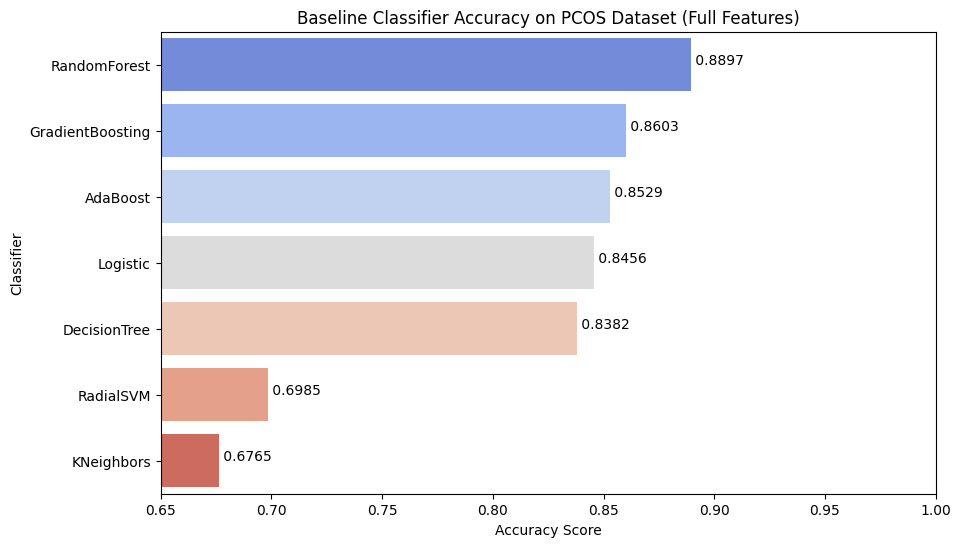

In [ ]:
score_pcos = acc_score(data_pcos, label_pcos)
print("Baseline Accuracy on PCOS Dataset:")
print(score_pcos)

plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Classifier', data=score_pcos, palette='coolwarm')
plt.title('Baseline Classifier Accuracy on PCOS Dataset (Full Features)')
plt.xlabel('Accuracy Score')
plt.ylabel('Classifier')

plt.xlim(0.65, 1.0)

for index, value in enumerate(score_pcos['Accuracy']):
    plt.text(value, index, f' {value:.4f}')

plt.savefig('pcos_baseline_accuracy.png', bbox_inches='tight')
plt.show()

#### Choosing the best classifier for further calculations

--- Starting Genetic Algorithm for Each Classifier ---

Model currently training: RadialSVM
Best score in generation 1 : [np.float64(0.6985294117647058)]
Best score in generation 2 : [np.float64(0.6985294117647058)]
Best score in generation 3 : [np.float64(0.6985294117647058)]
Best score in generation 4 : [np.float64(0.6985294117647058)]
Best score in generation 5 : [np.float64(0.7426470588235294)]

Model currently training: Logistic
Best score in generation 1 : [np.float64(0.8970588235294118)]
Best score in generation 2 : [np.float64(0.8970588235294118)]
Best score in generation 3 : [np.float64(0.8897058823529411)]
Best score in generation 4 : [np.float64(0.8897058823529411)]
Best score in generation 5 : [np.float64(0.8970588235294118)]

Model currently training: RandomForest
Best score in generation 1 : [np.float64(0.9117647058823529)]
Best score in generation 2 : [np.float64(0.9117647058823529)]
Best score in generation 3 : [np.float64(0.9044117647058824)]
Best score in generation 4

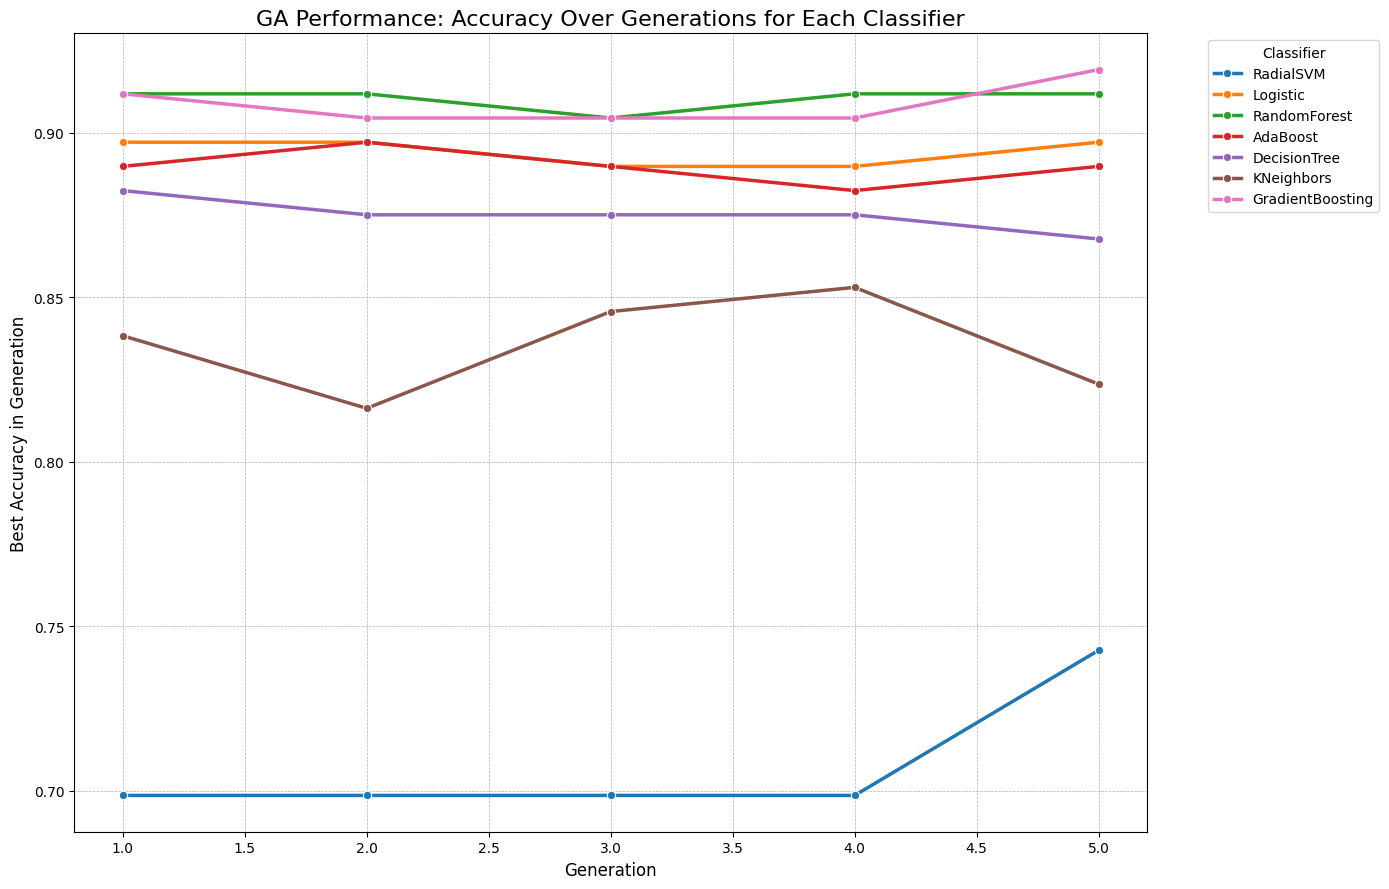

In [ ]:
all_model_scores = {}
print("--- Starting Genetic Algorithm for Each Classifier ---")

for model, model_name in zip(models, classifiers):
    print(f"\nModel currently training: {model_name}")

    globals()['logmodel'] = model

    X_train, X_test, Y_train, Y_test = split(data_pcos, label_pcos)

    _, scores_per_generation = generations(
        df=data_pcos,
        label=label_pcos,
        size=80,
        n_feat=data_pcos.shape[1],
        n_parents=64,
        mutation_rate=0.20,
        n_gen=5,
        X_train=X_train,
        X_test=X_test,
        Y_train=Y_train,
        Y_test=Y_test
    )

    all_model_scores[model_name] = scores_per_generation

print("\n--- Genetic Algorithm Training Complete for All Models ---")


results_df = pd.DataFrame(all_model_scores)
results_df['Generation'] = range(1, len(results_df) + 1)

results_melted = results_df.melt(id_vars='Generation', var_name='Classifier', value_name='Accuracy')

plt.figure(figsize=(14, 9))
sns.lineplot(data=results_melted, x='Generation', y='Accuracy', hue='Classifier', marker='o', palette='tab10', linewidth=2.5)

plt.title('GA Performance: Accuracy Over Generations for Each Classifier', fontsize=16)
plt.ylabel('Best Accuracy in Generation', fontsize=12)
plt.xlabel('Generation', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(title='Classifier', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('pcos_ga_all_models_comparison.png')
plt.show()

## PCA

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    data_pcos, label_pcos, test_size=0.25, random_state=0
)

--- Starting PCA Pipeline for Each Classifier ---

Model currently training: RadialSVM
Test Accuracy with PCA: 0.6912

Model currently training: Logistic
Test Accuracy with PCA: 0.6985

Model currently training: RandomForest
Test Accuracy with PCA: 0.6838

Model currently training: AdaBoost
Test Accuracy with PCA: 0.6838

Model currently training: DecisionTree
Test Accuracy with PCA: 0.6765

Model currently training: KNeighbors
Test Accuracy with PCA: 0.6176

Model currently training: GradientBoosting
Test Accuracy with PCA: 0.6250

--- PCA Pipeline Training Complete ---

Classifier Performance After PCA:
         Classifier  Accuracy
0          Logistic  0.698529
1         RadialSVM  0.691176
2      RandomForest  0.683824
3          AdaBoost  0.683824
4      DecisionTree  0.676471
5  GradientBoosting  0.625000
6        KNeighbors  0.617647


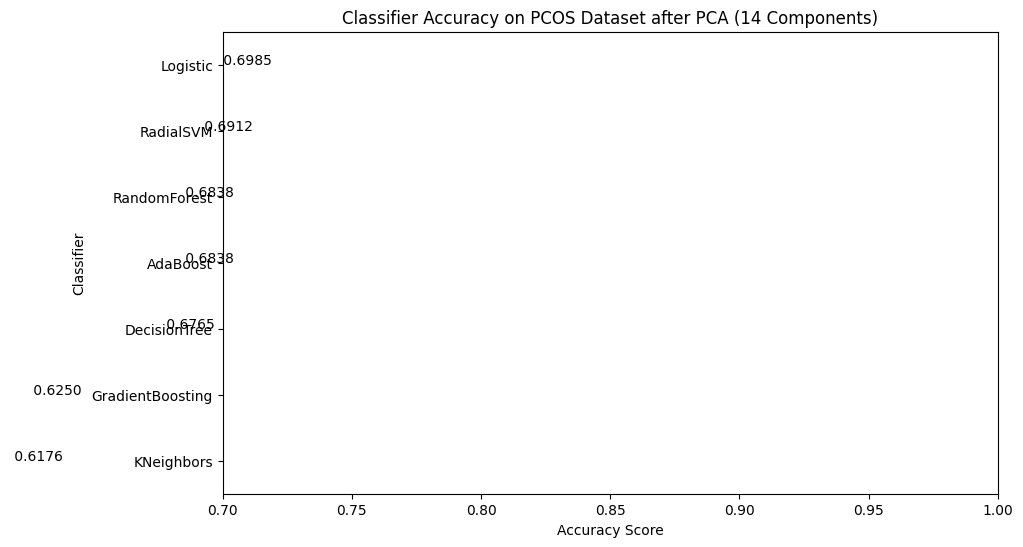

In [ ]:
pca_results = []
print("--- Starting PCA Pipeline for Each Classifier ---")

for model, model_name in zip(models, classifiers):
    print(f"\nModel currently training: {model_name}")

    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components=14)),
        ('classifier', model)
    ])

    pipeline.fit(X_train, Y_train)

    accuracy = pipeline.score(X_test, Y_test)
    print(f"Test Accuracy with PCA: {accuracy:.4f}")

    pca_results.append({'Classifier': model_name, 'Accuracy': accuracy})

print("\n--- PCA Pipeline Training Complete ---")

pca_results_df = pd.DataFrame(pca_results)
pca_results_df.sort_values(by='Accuracy', ascending=False, inplace=True)
pca_results_df.reset_index(drop=True, inplace=True)

print("\nClassifier Performance After PCA:")
print(pca_results_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Accuracy', y='Classifier', data=pca_results_df, palette='plasma', orient='h')

plt.title('Classifier Accuracy on PCOS Dataset after PCA (14 Components)')
plt.xlabel('Accuracy Score')
plt.ylabel('Classifier')
plt.xlim(0.7, 1.0)

for index, value in enumerate(pca_results_df['Accuracy']):
    plt.text(value, index, f' {value:.4f}')

plt.savefig('pcos_pca_accuracy_comparison.png', bbox_inches='tight')
plt.show()

## Implement pso

### Subtask:
Create functions for the PSO algorithm, including initialization, updating particle positions and velocities, and evaluating fitness.


In [ ]:
import random

def initialize_particles(num_particles, num_features):

    particles = []
    for _ in range(num_particles):
        position = np.random.randint(2, size=num_features).astype(bool)
        velocity = np.zeros(num_features)
        particles.append({
            'position': position,
            'velocity': velocity,
            'personal_best_position': position.copy(),
            'personal_best_fitness': -np.inf  # Initialize with negative infinity
        })
    return particles

In [ ]:
def update_velocity(particle, global_best_position, w, c1, c2):

    r1 = np.random.random(len(particle['position']))
    r2 = np.random.random(len(particle['position']))

    # Use bitwise XOR for boolean arrays instead of subtraction
    cognitive_velocity = c1 * r1 * (particle['personal_best_position'] ^ particle['position'])
    social_velocity = c2 * r2 * (global_best_position ^ particle['position'])
    new_velocity = w * particle['velocity'] + cognitive_velocity + social_velocity

    return new_velocity

In [ ]:
def update_position(particle, new_velocity):

    # Use a sigmoid function to map velocity to a probability
    sigmoid = 1 / (1 + np.exp(-new_velocity))

    # Update position based on probability
    new_position = (np.random.random(len(particle['position'])) < sigmoid).astype(bool)

    return new_position

In [ ]:
def evaluate_fitness(position, X_train, X_test, Y_train, Y_test, classifier):

    # Select features based on the particle's position
    selected_features_train = X_train.iloc[:, position]
    selected_features_test = X_test.iloc[:, position]

    # Ensure at least one feature is selected
    if selected_features_train.shape[1] == 0:
        return 0.0  # Return 0 accuracy if no features are selected

    # Train the classifier
    model = classifier
    model.fit(selected_features_train, Y_train)

    # Predict and evaluate
    predictions = model.predict(selected_features_test)
    accuracy = accuracy_score(Y_test, predictions)

    return accuracy

## Integrate pso with classifiers

### Subtask:
Modify the existing code to apply the PSO-based feature selection before training and evaluating each classifier.


**Reasoning**:
Define the main PSO function that orchestrates the particle updates and fitness evaluation over iterations, and then iterate through the classifiers, applying PSO for feature selection and evaluating the classifier performance with the selected features.



In [ ]:
def pso_feature_selection(X_train, X_test, Y_train, Y_test, classifier, num_particles=30, iterations=10, w=0.5, c1=2, c2=2):

    num_features = X_train.shape[1]
    particles = initialize_particles(num_particles, num_features)

    global_best_fitness = -np.inf
    global_best_position = None

    for i in range(iterations):
        print(f"  Iteration {i+1}/{iterations}")
        for particle in particles:
            # Evaluate fitness
            current_fitness = evaluate_fitness(particle['position'], X_train, X_test, Y_train, Y_test, classifier)

            # Update personal best
            if current_fitness > particle['personal_best_fitness']:
                particle['personal_best_fitness'] = current_fitness
                particle['personal_best_position'] = particle['position'].copy()

            # Update global best
            if current_fitness > global_best_fitness:
                global_best_fitness = current_fitness
                global_best_position = particle['position'].copy()

        # Update velocities and positions
        for particle in particles:
            new_velocity = update_velocity(particle, global_best_position, w, c1, c2)
            particle['velocity'] = new_velocity
            particle['position'] = update_position(particle, new_velocity)

    return global_best_position, global_best_fitness

print("--- Starting PSO Feature Selection for Each Classifier ---")

pso_results = []
X_train, X_test, Y_train, Y_test = split(data_pcos, label_pcos) # Use the same split as before

for model, model_name in zip(models, classifiers):
    print(f"\nModel currently training with PSO: {model_name}")

    # Perform PSO feature selection
    best_feature_subset, best_accuracy = pso_feature_selection(
        X_train, X_test, Y_train, Y_test, model,
        num_particles=30, iterations=10, w=0.5, c1=2, c2=2
    )

    print(f"  Best accuracy with PSO selected features: {best_accuracy:.4f}")

    # Store results
    pso_results.append({'Classifier': model_name, 'Accuracy': best_accuracy})

print("\n--- PSO Feature Selection Complete ---")

pso_results_df = pd.DataFrame(pso_results)
pso_results_df.sort_values(by='Accuracy', ascending=False, inplace=True)
pso_results_df.reset_index(drop=True, inplace=True)

print("\nClassifier Performance After PSO Feature Selection:")
display(pso_results_df)

--- Starting PSO Feature Selection for Each Classifier ---

Model currently training with PSO: RadialSVM
  Iteration 1/10
  Iteration 2/10
  Iteration 3/10
  Iteration 4/10
  Iteration 5/10
  Iteration 6/10
  Iteration 7/10
  Iteration 8/10
  Iteration 9/10
  Iteration 10/10
  Best accuracy with PSO selected features: 0.7059

Model currently training with PSO: Logistic
  Iteration 1/10
  Iteration 2/10
  Iteration 3/10
  Iteration 4/10
  Iteration 5/10
  Iteration 6/10
  Iteration 7/10
  Iteration 8/10
  Iteration 9/10
  Iteration 10/10
  Best accuracy with PSO selected features: 0.9191

Model currently training with PSO: RandomForest
  Iteration 1/10
  Iteration 2/10
  Iteration 3/10
  Iteration 4/10
  Iteration 5/10
  Iteration 6/10
  Iteration 7/10
  Iteration 8/10
  Iteration 9/10
  Iteration 10/10
  Best accuracy with PSO selected features: 0.9191

Model currently training with PSO: AdaBoost
  Iteration 1/10
  Iteration 2/10
  Iteration 3/10
  Iteration 4/10
  Iteration 5/10
  Ite

,Classifier,Accuracy
0,Logistic,0.919118
1,RandomForest,0.919118
2,GradientBoosting,0.904412
3,AdaBoost,0.897059
4,DecisionTree,0.875000
5,KNeighbors,0.830882
6,RadialSVM,0.705882


## Implement aco feature selection

### Subtask:
Define functions for the ACO algorithm, including initialization of ants, pheromone trails, and the feature selection process based on pheromone levels and heuristic information.


In [ ]:
def initialize_pheromones(num_features, initial_pheromone=1.0):
    """Initializes pheromone trails for each feature."""
    return np.full(num_features, initial_pheromone)

In [ ]:
def select_feature(current_features, pheromones, heuristic_info, alpha, beta):
    """Selects the next feature based on pheromone and heuristic information."""
    num_features = len(pheromones)
    probabilities = np.zeros(num_features)
    total_probability = 0

    for i in range(num_features):
        if not current_features[i]:  # Only consider features not yet selected
            # Calculate desirability: pheromone^alpha * heuristic^beta
            desirability = (pheromones[i]**alpha) * (heuristic_info[i]**beta)
            probabilities[i] = desirability
            total_probability += desirability

    # Avoid division by zero if no features are available or desirable
    if total_probability == 0:
        # If no unselected features or all desirability is zero, randomly pick one unselected feature
        unselected_indices = np.where(~current_features)[0]
        if len(unselected_indices) > 0:
            return np.random.choice(unselected_indices)
        else:
            return -1 # Indicate no feature can be selected (should not happen with at least one feature)


    # Normalize probabilities
    probabilities /= total_probability

    # Select feature based on probabilities
    selected_feature_index = np.random.choice(num_features, p=probabilities)

    return selected_feature_index

In [ ]:
def construct_solution(num_features, pheromones, heuristic_info, alpha, beta, X_train, X_test, Y_train, Y_test, classifier):
    """Constructs a feature subset solution for a single ant."""
    current_features = np.zeros(num_features, dtype=np.bool)
    selected_indices = []

    # Ensure at least one feature is selected
    initial_feature = random.randint(0, num_features - 1)
    current_features[initial_feature] = True
    selected_indices.append(initial_feature)

    # Build the rest of the solution
    for _ in range(num_features - 1): # Try to select up to num_features features
        next_feature_index = select_feature(current_features, pheromones, heuristic_info, alpha, beta)
        if next_feature_index != -1 and not current_features[next_feature_index]:
            current_features[next_feature_index] = True
            selected_indices.append(next_feature_index)
        # If no valid feature is selected, break (e.g., all features already selected)
        elif next_feature_index == -1 or current_features[next_feature_index]:
            break


    # Evaluate the fitness of the selected feature subset
    fitness = evaluate_fitness(current_features, X_train, X_test, Y_train, Y_test, classifier)

    return current_features, fitness

In [ ]:
def update_pheromones(pheromones, ant_solutions, decay_rate):
    """Updates pheromone levels based on ant solutions."""
    # Pheromone evaporation
    pheromones *= (1 - decay_rate)

    # Pheromone deposition
    for solution, fitness in ant_solutions:
        # Deposit pheromone on the trails used by the ant
        # A simple approach: deposit proportional to fitness on selected features
        pheromones[solution] += fitness

In [ ]:
def aco_feature_selection(X_train, X_test, Y_train, Y_test, classifier, num_ants=30, generations_aco=10, alpha=1.0, beta=2.0, decay_rate=0.1):

    num_features = X_train.shape[1]
    pheromones = initialize_pheromones(num_features)

    global_best_fitness = -np.inf
    global_best_position = None

    # Use a simple heuristic: the correlation of each feature with the label
    # Ensure the heuristic is non-negative and handle potential NaN/infinite values
    correlation = data_pcos.corrwith(label_pcos).abs()
    heuristic_info = correlation.fillna(0).replace([np.inf, -np.inf], 0) # Handle potential NaNs and infinities


    for gen in range(generations_aco):
        print(f"  Generation {gen+1}/{generations_aco}")
        ant_solutions = []
        for ant in range(num_ants):
            solution, fitness = construct_solution(num_features, pheromones, heuristic_info, alpha, beta, X_train, X_test, Y_train, Y_test, classifier)
            ant_solutions.append((solution, fitness))

            # Update global best
            if fitness > global_best_fitness:
                global_best_fitness = fitness
                global_best_position = solution.copy()

        # Update pheromones based on all ant solutions in the generation
        update_pheromones(pheromones, ant_solutions, decay_rate)

    return global_best_position, global_best_fitness

print("--- Starting ACO Feature Selection for Each Classifier ---")

aco_results = []
# Use the same split as before for consistency
# X_train, X_test, Y_train, Y_test are already defined from the previous split for PSO/GA
# X_train, X_test, Y_train, Y_test = split(data_pcos, label_pcos)

for model, model_name in zip(models, classifiers):
    print(f"\nModel currently training with ACO: {model_name}")

    # Perform ACO feature selection
    best_feature_subset_aco, best_accuracy_aco = aco_feature_selection(
        X_train, X_test, Y_train, Y_test, model,
        num_ants=30, generations_aco=10, alpha=1.0, beta=2.0, decay_rate=0.1
    )

    print(f"  Best accuracy with ACO selected features: {best_accuracy_aco:.4f}")

    # Store results
    aco_results.append({'Classifier': model_name, 'Accuracy': best_accuracy_aco})

print("\n--- ACO Feature Selection Complete ---")

aco_results_df = pd.DataFrame(aco_results)
aco_results_df.sort_values(by='Accuracy', ascending=False, inplace=True)
aco_results_df.reset_index(drop=True, inplace=True)

print("\nClassifier Performance After ACO Feature Selection:")
display(aco_results_df)

--- Starting ACO Feature Selection for Each Classifier ---

Model currently training with ACO: RadialSVM
  Generation 1/10
  Generation 2/10
  Generation 3/10
  Generation 4/10
  Generation 5/10
  Generation 6/10
  Generation 7/10
  Generation 8/10
  Generation 9/10
  Generation 10/10
  Best accuracy with ACO selected features: 0.6985

Model currently training with ACO: Logistic
  Generation 1/10
  Generation 2/10
  Generation 3/10
  Generation 4/10
  Generation 5/10
  Generation 6/10
  Generation 7/10
  Generation 8/10
  Generation 9/10
  Generation 10/10
  Best accuracy with ACO selected features: 0.8456

Model currently training with ACO: RandomForest
  Generation 1/10
  Generation 2/10
  Generation 3/10
  Generation 4/10
  Generation 5/10
  Generation 6/10
  Generation 7/10
  Generation 8/10
  Generation 9/10
  Generation 10/10
  Best accuracy with ACO selected features: 0.8897

Model currently training with ACO: AdaBoost
  Generation 1/10
  Generation 2/10
  Generation 3/10
  Gene

,Classifier,Accuracy
0,RandomForest,0.889706
1,GradientBoosting,0.860294
2,AdaBoost,0.852941
3,Logistic,0.845588
4,DecisionTree,0.838235
5,RadialSVM,0.698529
6,KNeighbors,0.676471


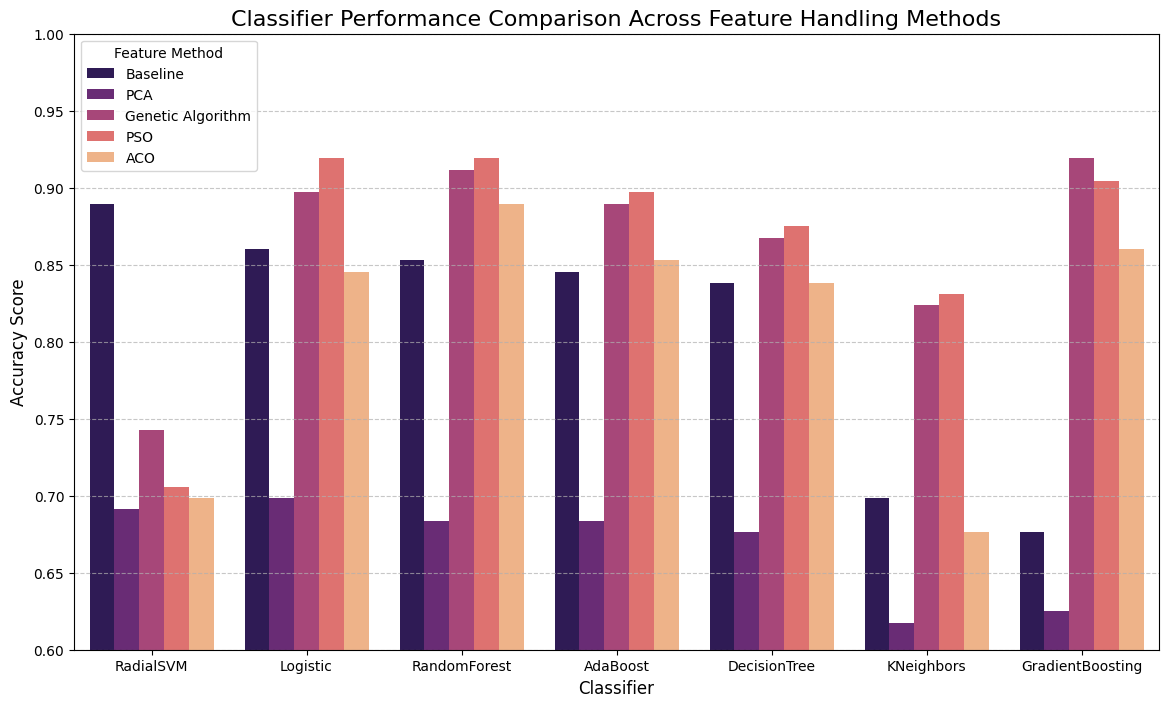

In [ ]:
comparison_data = {
    'Classifier': classifiers,
    'Baseline': score_pcos['Accuracy'].tolist(),
    'PCA': pca_results_df.set_index('Classifier').reindex(classifiers)['Accuracy'].tolist(),
    'Genetic Algorithm': results_df.iloc[-1, :-1].tolist(), # Using the last generation's scores from GA
    'PSO': pso_results_df.set_index('Classifier').reindex(classifiers)['Accuracy'].tolist(),
    'ACO': aco_results_df.set_index('Classifier').reindex(classifiers)['Accuracy'].tolist()
}

# Ensure all lists in comparison_data have the same length as 'Classifier'
max_len = len(classifiers)
for key in comparison_data:
    if len(comparison_data[key]) > max_len:
        comparison_data[key] = comparison_data[key][:max_len]
    while len(comparison_data[key]) < max_len:
        comparison_data[key].append(np.nan) # Pad with NaN if necessary

comp_df = pd.DataFrame(comparison_data)

comp_melted = comp_df.melt(id_vars='Classifier', var_name='Method', value_name='Accuracy')

plt.figure(figsize=(14, 8))
ax = sns.barplot(x='Classifier', y='Accuracy', hue='Method', data=comp_melted, palette='magma')

plt.title('Classifier Performance Comparison Across Feature Handling Methods', fontsize=16)
plt.ylabel('Accuracy Score', fontsize=12)
plt.xlabel('Classifier', fontsize=12)
plt.ylim(0.6, 1.0)
plt.legend(title='Feature Method')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig('detailed_classifier_comparison_with_aco.png', bbox_inches='tight')
plt.show()

**Reasoning**:
The previous step successfully added the ACO results to the comparison data and generated the comparison plot. Now, update the peak performance comparison to include the ACO results.



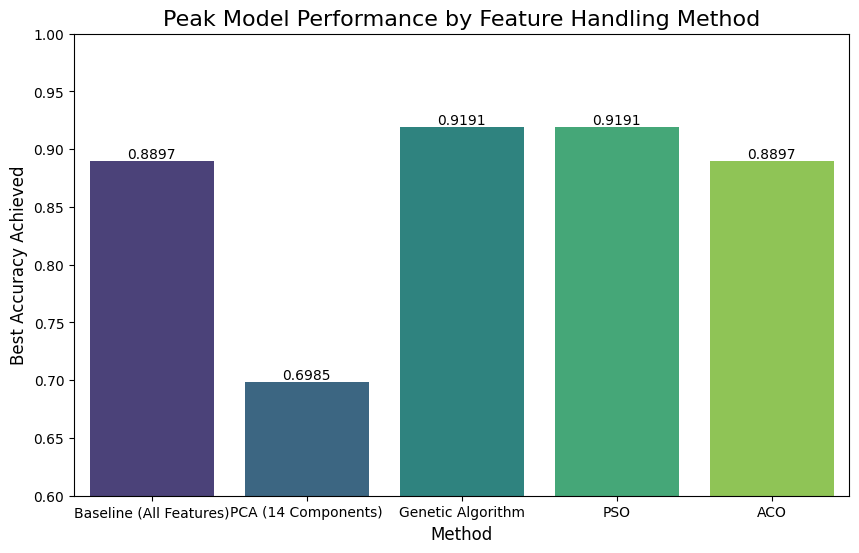

In [ ]:
peak_performance_data = {
    'Method': ['Baseline (All Features)', 'PCA (14 Components)', 'Genetic Algorithm', 'PSO', 'ACO'],
    'Highest Accuracy': [score_pcos['Accuracy'].max(), pca_results_df['Accuracy'].max(), results_df.drop('Generation', axis=1).max().max(), pso_results_df['Accuracy'].max(), aco_results_df['Accuracy'].max()]
}
peak_df = pd.DataFrame(peak_performance_data)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Method', y='Highest Accuracy', data=peak_df, palette='viridis')

plt.title('Peak Model Performance by Feature Handling Method', fontsize=16)
plt.ylabel('Best Accuracy Achieved', fontsize=12)
plt.xlabel('Method', fontsize=12)
plt.ylim(0.6, 1.0)

for p in ax.patches:
    ax.annotate(f'{p.get_height():.4f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

plt.savefig('peak_performance_comparison_with_aco.png', bbox_inches='tight')
plt.show()